In [42]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import requests
from shapely.geometry import Point
from datetime import datetime
from tqdm import tqdm
import time
from collections import defaultdict
import seaborn as sns
from prophet import Prophet
from scipy.optimize import curve_fit
import numpy as n
from scipy.interpolate import CubicSpline
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import pickle
from scipy.stats import linregress
import ipyparallel as ipp
import numpy as np

In [2]:
def fetch_counts_for_year(year):
    counts_for_year = defaultdict(int)
    offset = 0
    limit = 10000
    while True:
        url = (
            f"https://data.cnra.ca.gov/api/3/action/datastore_search?"
            f"resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266"
            f"&q={year}&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            for record in records:
                site_code = record.get('site_code')
                if record.get('gse_gwe') is None:
                    continue
                if site_code:
                    counts_for_year[site_code] += 1
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for year {year}")
            break
    return counts_for_year

rc = ipp.Client()
dview = rc[:]

with dview.sync_imports():
    import requests
    from collections import defaultdict

dview.push({'fetch_counts_for_year': fetch_counts_for_year})

years = list(range(2008, 2025))

async_results = dview.map_async(fetch_counts_for_year, years)
results = async_results.get()

counts = defaultdict(lambda: defaultdict(int))
for year, year_counts in zip(years, results):
    for site_code, count in year_counts.items():
        counts[site_code][year] = count

obs_df = pd.DataFrame.from_dict(counts, orient='index')
obs_df = obs_df.fillna(0).astype(int)
obs_df.columns = [f'observations_{year}' for year in obs_df.columns]
obs_df = obs_df.reset_index().rename(columns={'index': 'site_code'})

importing requests on engine(s)
importing defaultdict from collections on engine(s)


In [5]:
observation_columns = [col for col in obs_df.columns if col.startswith('observations_')]
ov25 = obs_df[obs_df[observation_columns].ge(25).all(axis=1)]

In [11]:
central = pd.read_csv("../data/central_stations_observations.csv")
cent_5021 = central[central.Basin_Subb.str.startswith("5-021")]

In [14]:
ov25_5021 = ov25[ov25.site_code.isin(cent_5021.site_code)].copy()

In [18]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = f"https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266&q={site_code} {year}&limit={limit}&offset={offset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in years:
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

def interpolate_gwe(site_code, years, readings_df):
    site_data = readings_df
    site_data.rename(columns={"msmt_date": "ds", "gwe": "y"}, inplace=True)
    site_data['ds'] = pd.to_datetime(site_data['ds'])

    full_date_range = pd.date_range(start=f"{min(years)}-01-01", end=f"{max(years)}-12-31", freq="D")
    full_df = pd.DataFrame({'ds': full_date_range})
    full_df = full_df.merge(site_data, on='ds', how='left')

    m = Prophet(
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.01,
        yearly_seasonality=True
    )
    m.fit(site_data.dropna())

    forecast = m.predict(full_df)

    full_df['y_interpolated'] = forecast['yhat']

    result_df = full_df[['ds', 'y_interpolated']].copy()
    result_df.rename(columns={"ds": "date", "y_interpolated": "gwe_interpolated"}, inplace=True)

    return result_df

def gwe_trend(site_code, start_yr, end_yr):
    years = range(start_yr, end_yr + 1)
    readings_df = get_readings_for_site(site_code, years)
    predicted = interpolate_gwe(site_code, years, readings_df)

    predicted['date'] = pd.to_datetime(predicted['date'])
    predicted.set_index('date', inplace=True)

    monthly_avg = predicted.resample('M').mean()
    
    return monthly_avg

In [19]:
client = ipp.Client()
dview = client[:]
dview.push({'fetch_all_records': fetch_all_records,
           'get_readings_for_site':get_readings_for_site,
           'interpolate_gwe':interpolate_gwe,
           'gwe_trend':gwe_trend})

dview.execute("""
import pandas as pd
import requests
from prophet import Prophet
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
""")

view = client.load_balanced_view()

well_gwe_trends = {}

def process_well(well):
    return well, gwe_trend(well, 2008, 2024)

async_results = []
for well in ov25_5021.site_code.unique():
    async_result = view.apply_async(process_well, well)
    async_results.append(async_result)

for async_result in async_results:
    try:
        well, result = async_result.get()
        well_gwe_trends[well] = result
    except Exception as e:
        print(f"Error processing well {well}: {e}")

In [123]:
def calculate_groundwater_changes(data_dict):
    result_dict = {}
    for year in range(2008, 2024):
        year_dict = {}

        for site_code, df in data_dict.items():
            try:
                october_value = df.loc[f'{year}-10-31'].iloc[0]
                september_value = df.loc[f'{year+1}-09-30'].iloc[0]
                change = october_value - september_value
                year_dict[site_code] = change
            except KeyError:
                print(f"Warning: Missing data for site {site_code} in year {year} or {year+1}.")
                year_dict[site_code] = None

        result_dict[year] = year_dict

    return result_dict

In [124]:
well_changes = calculate_groundwater_changes(well_gwe_trends)

In [35]:
def get_precipitation_data(latitude, longitude, start_date, end_date, parameter="PRECTOTCORR"):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    params = {
        "parameters": parameter,
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()

    try:
        precip_data = data["properties"]["parameter"][parameter]
    except KeyError as e:
        raise ValueError(f"Unable to retrieve parameter '{parameter}' from response: {e}")

    return precip_data

def process_precipitation_data(precip_data):
    df = pd.DataFrame.from_dict(precip_data, orient="index", columns=["precipitation"])
    df.index = pd.to_datetime(df.index)
    monthly_avg = df.resample("M").mean()
    
    return monthly_avg

def get_monthly_precipitation_for_sites(df, start_date=2008, end_date=2024):
    result_dict = {}

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing sites"):
        site_code = row["site_code"]
        latitude = row["latitude"]
        longitude = row["longitude"]

        try:
            precip_data = get_precipitation_data(latitude, longitude, start_date, end_date)
            monthly_avg = process_precipitation_data(precip_data)
            result_dict[site_code] = monthly_avg

        except Exception as e:
            print(f"Error processing site {site_code}: {e}")
            result_dict[site_code] = None

    return result_dict

In [31]:
ov25_5021 = pd.merge(ov25_5021, central[["site_code", "latitude", "longitude", "well_depth"]], on="site_code", how="inner")

In [36]:
precipitation_data = get_monthly_precipitation_for_sites(ov25_5021)

Processing sites: 100%|██████████| 167/167 [05:56<00:00,  2.13s/it]


In [38]:
def calculate_annual_precipitation_averages(precipitation_dict):
    result_dict = {}
    for year in range(2008, 2024):
        year_dict = {}
        for site_code, monthly_avg in precipitation_dict.items():
            if monthly_avg is not None:
                try:
                    start_date = f"{year}-10-31"
                    end_date = f"{year+1}-09-30"
                    period_data = monthly_avg.loc[start_date:end_date]
                    average_precip = period_data["precipitation"].mean()
                    year_dict[site_code] = average_precip
                except KeyError:
                    print(f"Warning: Missing data for site {site_code} in year {year}.")
                    year_dict[site_code] = None
        result_dict[year] = year_dict
    return result_dict

In [39]:
well_precipitation = calculate_annual_precipitation_averages(precipitation_data)

In [57]:
wells = {}
for year, sites in well_precipitation.items():
    for site, precip in sites.items():
        wells.setdefault(site, []).append((year, precip))

SD_beneath = {}
for site, values in wells.items():
    precip_values = [precip for _, precip in values]
    mean_val = np.mean(precip_values)
    std_val = np.std(precip_values)
    threshold = mean_val - 0.5 * std_val
    SD_beneath[site] = [year for year, precip in values if precip < threshold]

In [125]:
gradients = {}
for site, years in SD_beneath.items():
    x = []
    y = []
    for year in years:
        if (year in well_precipitation and site in well_precipitation[year] and
            year in well_changes and site in well_changes[year]):
            x.append(well_precipitation[year][site])
            y.append(well_changes[year][site])
    if len(x) > 1:
        reg_result = linregress(x, y)
        gradients[site] = {"slope": reg_result.slope, "p_value": reg_result.pvalue}
    else:
        gradients[site] = {"slope": None, "p_value": None}

In [126]:
ov25_5021['gradient'] = ov25_5021['site_code'].map(lambda x: gradients.get(x, {}).get("slope", None))

In [127]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

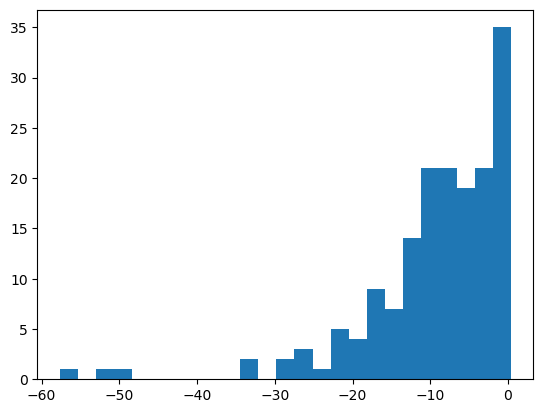

In [83]:
plt.hist(ov25_5021.gradient, bins=25)
plt.show()

In [96]:
stations_5021 = central[central.Basin_Subb.str.startswith("5-021")]
stations_5021 = stations_5021[~stations_5021.well_depth.isna()]

In [97]:
stations_5021

site_code  latitude  longitude  well_depth     well_use  \
2039  366909N1221638W001  39.69090 -122.16384       320.0   Irrigation   
3433  380926N1215871W001  38.11300 -121.58719        23.0  Observation   
3434  380926N1215871W002  38.11300 -121.58719       102.0  Observation   
3458  381132N1216951W001  38.11322 -121.69513       416.0        Other   
3462  381150N1215899W001  38.81150 -121.58993       340.0   Irrigation   
...                  ...       ...        ...         ...          ...   
5862  402341N1222533W002  40.23410 -122.25329       140.0   Industrial   
5865  402522N1222082W001  40.25221 -122.20818       200.0  Residential   
5866  402653N1222348W002  40.26517 -122.25339       320.0  Residential   
5964  410921N1210855W001  40.09211 -122.08555       680.0  Observation   
6037  417895N1210549W002  39.78953 -122.05494       250.0   Irrigation   

      geology Region_Off Basin_Subb  observations_2010  observations_2011  \
2039    ['Q']        NRO   5-021.52                  0                  0   
3433    ['Q']       NCRO   5-021.66                  0                  0   
3434    ['Q']       NCRO   5-021.66                  0                  0   
3458    ['Q']       NCRO   5-021.66                  0                  0   
3462    ['Q']       NCRO   5-021.64                  0                  0   
...       ...        ...        ...                ...                ...   
5862  ['QPc']        NRO   5-021.50                  0                  0   
5865  ['Tvp']        NRO   5-021.53                  0                  0   
5866  ['QPc']        NRO   5-021.50                  0                  0   
5964  ['QPc']        NRO   5-021.56                  0                  0   
6037    ['Q']        NRO   5-021.51                  0                  0   

      ...  observations_2015  observations_2016  observations_2017  \
2039  ...                  4                  3                  3   
3433  ...                  0                  0                  0   
3434  ...                  0                  0                  0   
3458  ...                  2                  2                  2   
3462  ...                 23                  3                  0   
...   ...                ...                ...                ...   
5862  ...                  0                  0                  0   
5865  ...                  0                  5                  3   
5866  ...                  0                  0                  0   
5964  ...                  0                  0                  0   
6037  ...                  0                  0                  0   

      observations_2018  observations_2019  observations_2020  \
2039                  3                  3                  3   
3433                  0                  0                  0   
3434                  0                  0                  0   
3458                  2                  2                  1   
3462                  0                  0                  0   
...                 ...                ...                ...   
5862                  0                  0                  0   
5865                  2                  3                  2   
5866                  0                  0                  0   
5964                  0                  0                  0   
6037                  0                  3                  3   

      observations_2021  observations_2022  observations_2023  \
2039                  3                  3                  3   
3433                  0                  0                  0   
3434                  0                  0                  0   
3458                  2                  0                  2   
3462                  0                  0                  0   
...                 ...                ...                ...   
5862                  4                  9                 10   
5865                  2                  3                 

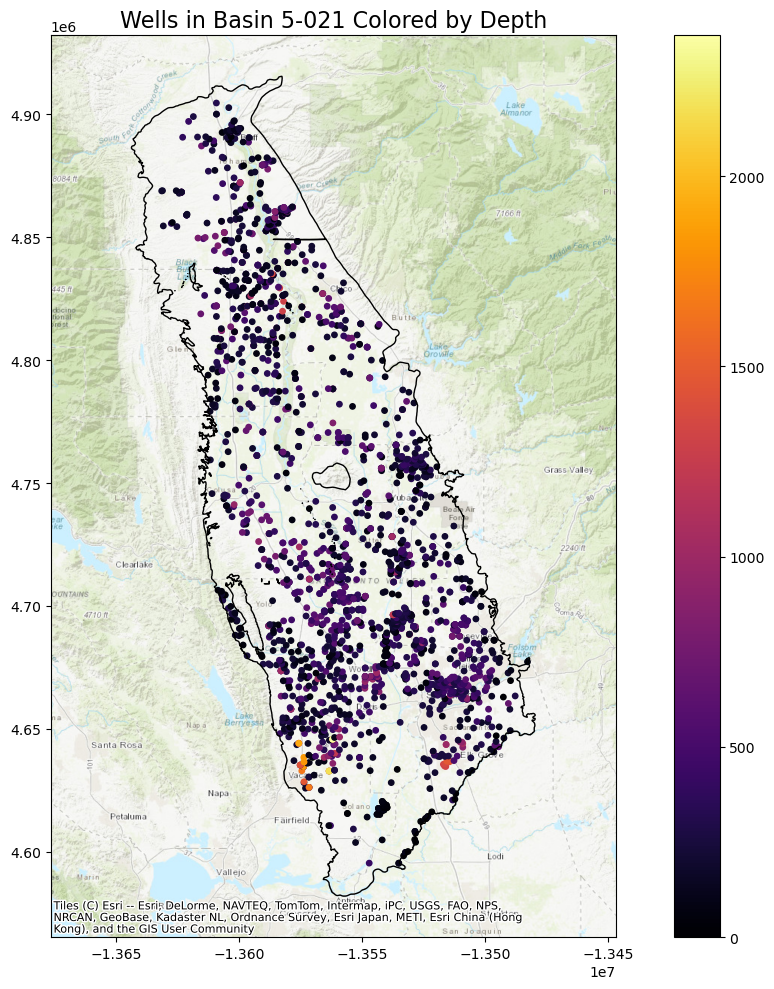

In [121]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# --- Convert your stations_5021 DataFrame into a GeoDataFrame ---
stations_gdf = gpd.GeoDataFrame(
    stations_5021,
    geometry=gpd.points_from_xy(stations_5021.longitude, stations_5021.latitude),
    crs="EPSG:4326"  # assuming the lat/lon are in WGS84
)

# --- Create the basin polygon for Basin 5-021 ---
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(geometry=[larger_polygon], crs=filtered_gdf.crs)

# --- Convert both GeoDataFrames to Web Mercator (EPSG:3857) ---
stations_gdf = stations_gdf.to_crs(epsg=3857)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=3857)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the basin polygon boundary and the well points.
larger_polygon_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
stations_gdf.plot(column='well_depth', ax=ax, cmap='inferno', marker='o', markersize=15, legend=True)

# Compute combined bounds from both the well points and basin polygon.
stations_bounds = stations_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
polygon_bounds = larger_polygon_gdf.total_bounds
xmin = min(stations_bounds[0], polygon_bounds[0])
ymin = min(stations_bounds[1], polygon_bounds[1])
xmax = max(stations_bounds[2], polygon_bounds[2])
ymax = max(stations_bounds[3], polygon_bounds[3])

# Add a margin (5% of the total range) around the bounds.
x_margin = 0.20 * (xmax - xmin)
y_margin = 0.05 * (ymax - ymin)
ax.set_xlim(xmin - x_margin, xmax + x_margin)
ax.set_ylim(ymin - y_margin, ymax + y_margin)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)

ax.set_title('Wells in Basin 5-021 Colored by Depth', fontsize=16)
plt.tight_layout()

plt.show()

In [145]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
data = []
for year, sites in well_changes.items():
    for site, change in sites.items():
        precip = well_precipitation.get(year, {}).get(site, None)
        if precip is not None:
            data.append({
                'year': year,
                'site_code': site,
                'change_in_GWE': change,
                'avg_precip': precip
            })

df = pd.DataFrame(data)

wells = df['site_code'].unique()

well_pca_results = {}

for well in wells:
    df_well = df[df['site_code'] == well]
    
    if len(df_well) < 2:
        print(f"Not enough data for well {well} to perform PCA.")
        continue
    
    X_well = df_well[['avg_precip', 'change_in_GWE']].values
    X_centered = X_well - np.mean(X_well, axis=0)
    
    pca = PCA(n_components=2)
    pca.fit(X_centered)
    
    pc1 = pca.components_[0]

    gradient = pc1[1] / pc1[0] if pc1[0] != 0 else np.nan
    
    well_pca_results[well] = {
        'pc1': pc1,
        'gradient': gradient,
        'explained_variance': pca.explained_variance_ratio_
    }

In [146]:
ov25_5021["pca_gradient"] = ov25_5021['site_code'].map(lambda x: well_pca_results.get(x, {}).get("gradient", None))

In [147]:
ov25_5021

site_code  observations_2008  observations_2009  \
0    384159N1217303W002                364                467   
1    400428N1221665W001                362                375   
2    400428N1221665W003                362                375   
3    386464N1216675W002                372                418   
4    399740N1219748W001                370                377   
..                  ...                ...                ...   
162  398543N1221535W001                369                375   
163  399078N1220721W003                221                221   
164  398543N1221535W004                369                375   
165  398996N1221227W001                369                324   
166  398619N1219746W001                371                240   

     observations_2010  observations_2011  observations_2012  \
0                  306                358                377   
1                  367                368                369   
2                  367                369                369   
3                  374                377                373   
4                  368                369                368   
..                 ...                ...                ...   
162                367                367                369   
163                152                369                368   
164                367                367                369   
165                366                178                368   
166                369                370                374   

     observations_2013  observations_2014  observations_2015  \
0                  377                371                326   
1                  367                367                287   
2                  367                367                319   
3                  387                400                407   
4                  367                369                366   
..                 ...                ...                ...   
162                261                366                442   
163                367                368                383   
164                367                367                383   
165                225                367                355   
166                368                371                419   

     observations_2016  ...  observations_2020  observations_2021  \
0                  382  ...                380                384   
1                  296  ...                105                251   
2                  265  ...                145                291   
3                  248  ...                367                325   
4                  369  ...                219                368   
..                 ...  ...                ...                ...   
162                371  ...                193                291   
163                369  ...                297                368   
164                374  ...                193                181   
165                235  ...                104                291   
166                295  ...                370                368   

     observations_2022  observations_2023  observations_2024  latitude  \
0                  384                269                197  38.41585   
1                  371                372                299  40.04281   
2                  369                370                301  40.04281   
3                  302                280                341  38.64640   
4                  368                368                295  39.97397   
..                 ...                ...                ...       ...   
162                371                375                302  39.85430   
163                368                368                224  39.90776   
164                104                375                302  39.85430   
165                371                375                303  39.89961   
166                373                377           

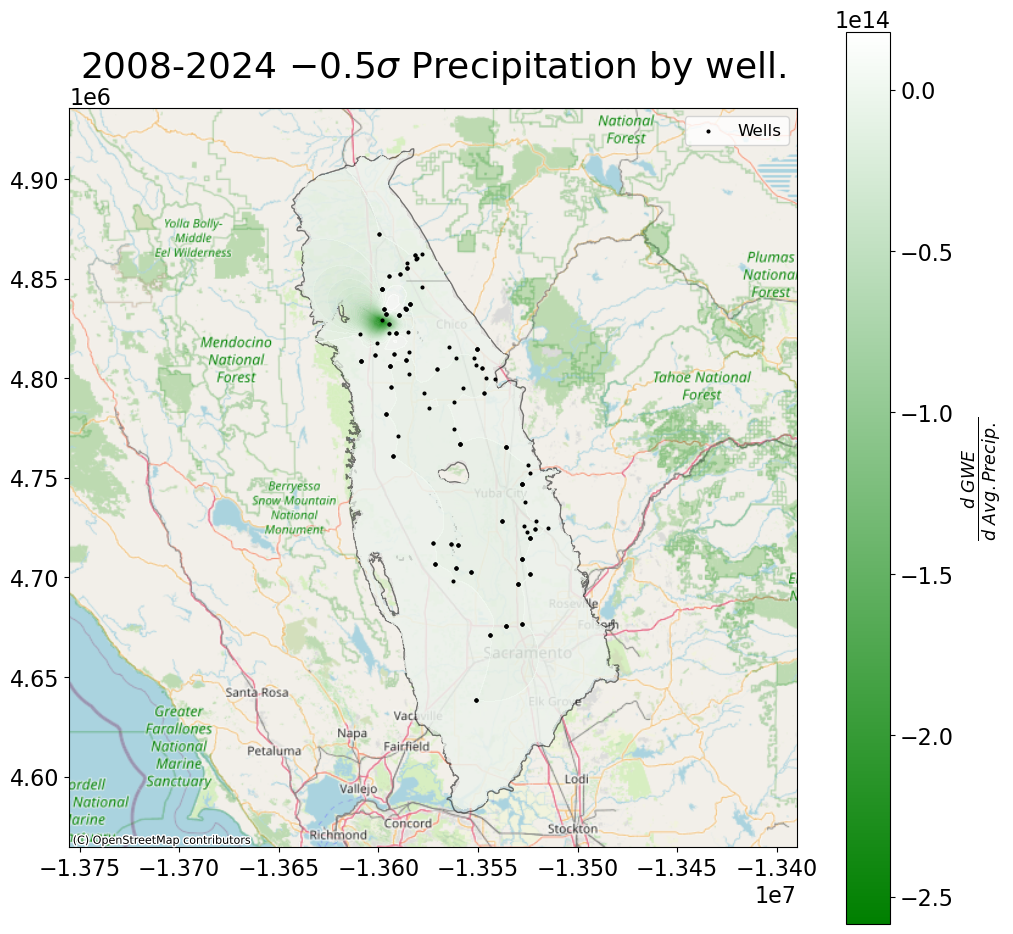

In [155]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 26,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 32
})

filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(
    geometry=[larger_polygon],
    crs=filtered_gdf.crs
)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    ov25_5021,
    geometry=gpd.points_from_xy(
        ov25_5021['longitude'], 
        ov25_5021['latitude']
    ),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y
z_slope = -np.exp(-wells_gdf['gradient'])

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok_slope = OrdinaryKriging(x, y, z_slope, variogram_model='linear')
z_interp_slope, ss_slope = ok_slope.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)
mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked_slope = np.ma.masked_where(~mask, z_interp_slope)

slope_vals = z_interp_masked_slope.compressed()
min_val = slope_vals.min()
max_val = slope_vals.max()
norm = mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=(min_val+max_val)/2, vmax=max_val)

colors = ["green", "white"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("brown_white_green", colors)

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)

larger_polygon_3857.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

contour_slope = ax.contourf(
    xx_3857, yy_3857,
    z_interp_masked_slope,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

wells_gdf_3857.plot(ax=ax, marker='.', color='black', markersize=15, label='Wells')
ctx.add_basemap(ax, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=16)
ax.set_aspect('equal')
ax.legend(fontsize=12)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(
    sm, 
    ax=ax,
    fraction=0.1,
    shrink=0.9,
    pad=0.02
)
cbar.set_label(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=18)

plt.title(f"2008-2024 $-0.5 \sigma$ Precipitation by well.")
plt.show()

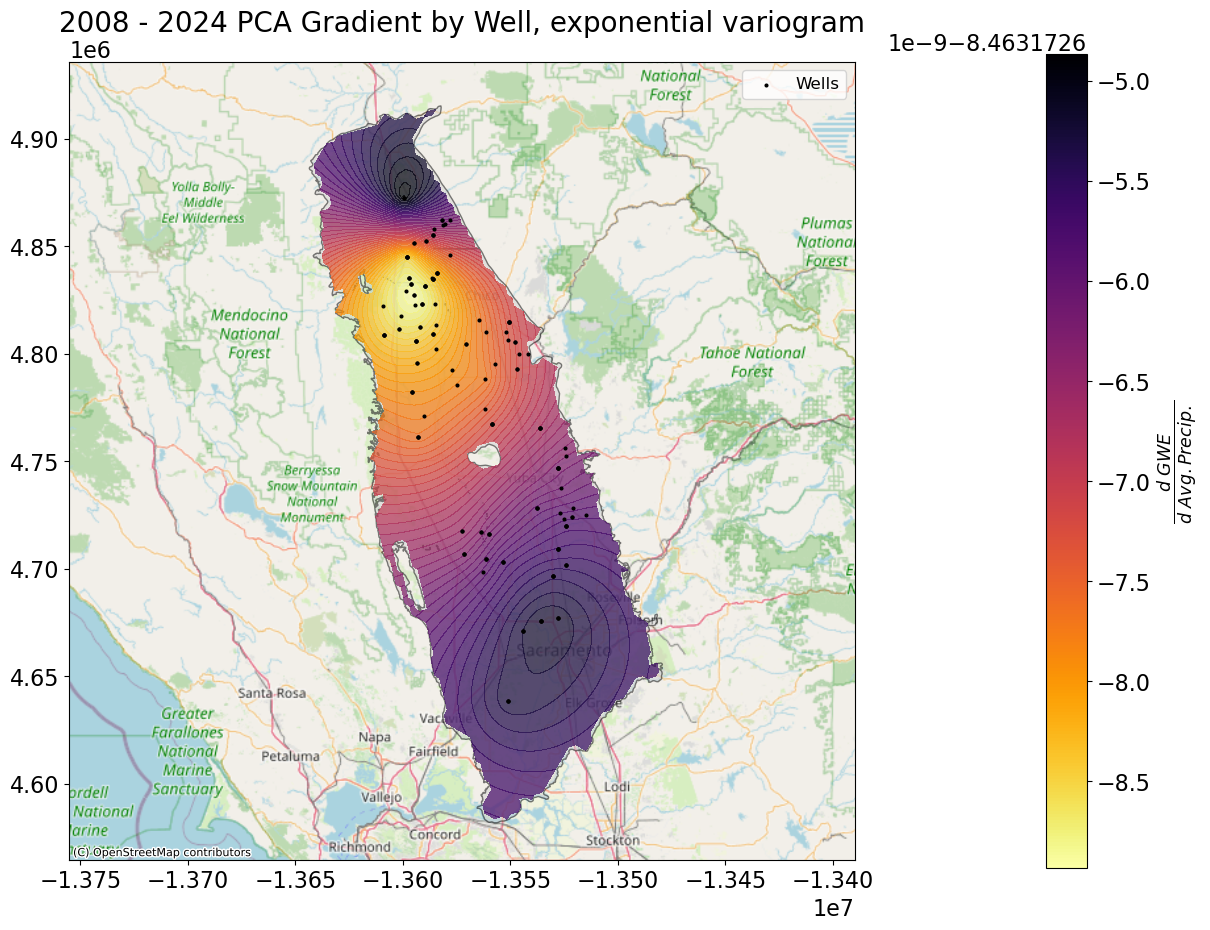

In [159]:
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(
    geometry=[larger_polygon],
    crs=filtered_gdf.crs
)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    ov25_5021,
    geometry=gpd.points_from_xy(
        ov25_5021['longitude'], 
        ov25_5021['latitude']
    ),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y
z_slope = wells_gdf['pca_gradient']

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok_slope = OrdinaryKriging(x, y, z_slope, variogram_model='exponential')
z_interp_slope, ss_slope = ok_slope.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)
mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked_slope = np.ma.masked_where(~mask, z_interp_slope)

slope_vals = z_interp_masked_slope.compressed()
min_val = slope_vals.min()
max_val = slope_vals.max()
norm = mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=(min_val+max_val)/2, vmax=max_val)

cmap = plt.cm.inferno_r

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)

larger_polygon_3857.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

contour_slope = ax.contourf(
    xx_3857, yy_3857,
    z_interp_masked_slope,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

wells_gdf_3857.plot(ax=ax, marker='.', color='black', markersize=15, label='Wells')
ctx.add_basemap(ax, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=16)
ax.set_aspect('equal')
ax.legend(fontsize=12)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(
    sm, 
    ax=ax,
    fraction=0.1,
    shrink=0.9,
    pad=0.02
)
cbar.set_label(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=18)

plt.title(f"2008 - 2024 PCA Gradient by Well, exponential variogram")
plt.show()

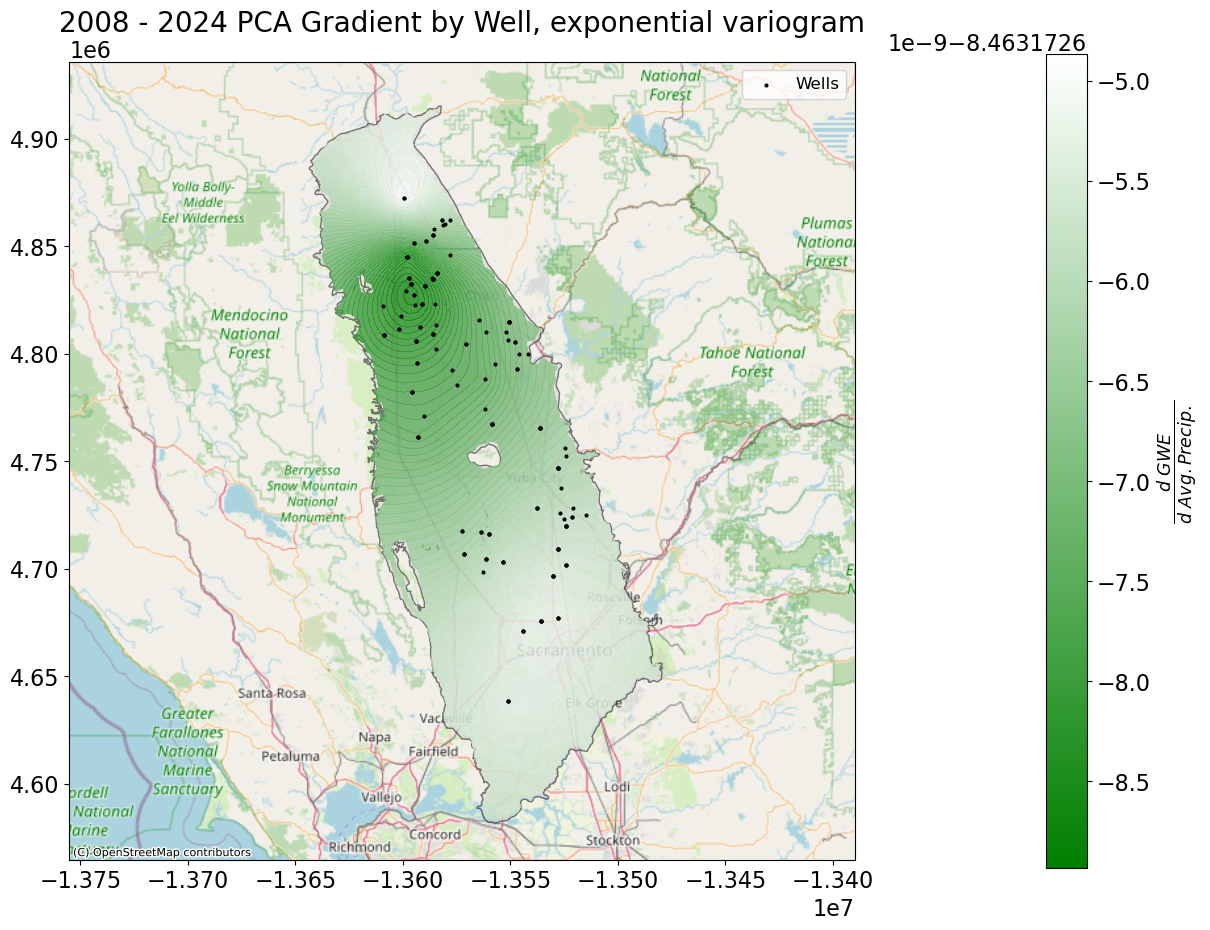

In [158]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 32
})

filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(
    geometry=[larger_polygon],
    crs=filtered_gdf.crs
)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    ov25_5021,
    geometry=gpd.points_from_xy(
        ov25_5021['longitude'], 
        ov25_5021['latitude']
    ),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y
z_slope = wells_gdf['pca_gradient']

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok_slope = OrdinaryKriging(x, y, z_slope, variogram_model='exponential')
z_interp_slope, ss_slope = ok_slope.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)
mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked_slope = np.ma.masked_where(~mask, z_interp_slope)

slope_vals = z_interp_masked_slope.compressed()
min_val = slope_vals.min()
max_val = slope_vals.max()
norm = mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=(min_val+max_val)/2, vmax=max_val)

colors = ["green", "white"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("brown_white_green", colors)

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)

larger_polygon_3857.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

contour_slope = ax.contourf(
    xx_3857, yy_3857,
    z_interp_masked_slope,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

wells_gdf_3857.plot(ax=ax, marker='.', color='black', markersize=15, label='Wells')
ctx.add_basemap(ax, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=16)
ax.set_aspect('equal')
ax.legend(fontsize=12)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(
    sm, 
    ax=ax,
    fraction=0.1,
    shrink=0.9,
    pad=0.02
)
cbar.set_label(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=18)

plt.title(f"2008 - 2024 PCA Gradient by Well, exponential variogram")
plt.show()